# CNN Lab

By: Charles Patterson

# Business Understanding

Today, the average salary of a radiologist is between 170k-460k according to glassdoor.  This is an extreme cost to out healthcare system to pay someone who has spent years learning about taking care of the human body to sit infront of a computer and preform a classification problem.  CNNs provide a promising solution.  By utilizing their ability to identify desease, like pnemonia, healthcare systems can spend less money on paying radiologists, and more money on helping people.  Furthermore, American talent with the intellectual capacity and desire to earn an MD no longer have to spend there days behind a computer, doing the computers job, but instead focus on help people in ways computers can't.  In this lab, I am going to use a CNN to identify people the people with xrays that indicate pnemonia with the goal of helping the healthcare industry maximize their ability to help others.

# Preparation

In [1]:
#Import all the libraries I want to use
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

In [2]:
xrays = []
labels = []

In [3]:
#Read the images as numpy arrays
def read_xrays(file_path, pneumonia = True):
    errors = 0
    all_xrays = glob.glob(file_path)
    for image in all_xrays:
        xray = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        xray = cv2.resize(xray, dsize = (75,75), interpolation=cv2.INTER_NEAREST)
        try:
            xrays.append(xray.flatten())
            if pneumonia:
                labels.append(1)
            else:
                labels.append(0)
                
        except:
            errors += 1
    return errors

In [4]:
%%time

#Read in data and make sure everything work okay
num_errors = 0
num_errors += read_xrays("chest_xray/chest_xray/train/NORMAL/*.jpeg", pneumonia = False)
num_errors += read_xrays("chest_xray/chest_xray/test/NORMAL/*.jpeg", pneumonia = False)
num_errors += read_xrays("chest_xray/train/NORMAL/*.jpeg", pneumonia = False)
num_errors += read_xrays("chest_xray/test/NORMAL/*.jpeg", pneumonia = False)
num_errors += read_xrays("chest_xray/val/NORMAL/*.jpeg", pneumonia = False)
print("Normal")
num_errors += read_xrays("chest_xray/chest_xray/train/PNEUMONIA/*.jpeg", pneumonia = True)
num_errors += read_xrays("chest_xray/chest_xray/test/PNEUMONIA/*.jpeg", pneumonia = True)
num_errors += read_xrays("chest_xray/train/PNEUMONIA/*.jpeg", pneumonia = True)
num_errors += read_xrays("chest_xray/test/PNEUMONIA/*.jpeg", pneumonia = True)
num_errors += read_xrays("chest_xray/val/PNEUMONIA/*.jpeg", pneumonia = True)
print("Pneumonia")

if num_errors > 0:
    print(num_errors, "images did not read correctly")
else:
    print("All images read fine")

Normal
Pneumonia
All images read fine
CPU times: user 1min 27s, sys: 9.08 s, total: 1min 36s
Wall time: 1min 49s


In [5]:
X = np.array(xrays)
y = np.array(labels)
print("There are", len(y), "xrays")
print("Pneumonia:", np.sum(y))
print("Normal:", len(y) - np.sum(y))

There are 11680 xrays
Pneumonia: 8530
Normal: 3150


In [6]:
import random
random.seed(1)

classes = {1:"Pnemonia", 0:"No Pnemonia"}

def plot_gallery(images, title, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    rand_sample = random.sample(range(0,images.shape[0]), k=18)
    for n,i in enumerate(rand_sample):
        plt.subplot(n_row, n_col, n + 1)
        plt.imshow(images[i].reshape((h,w)))
        plt.title(classes[title[i]], size=12)
        plt.xticks(())
        plt.yticks(())

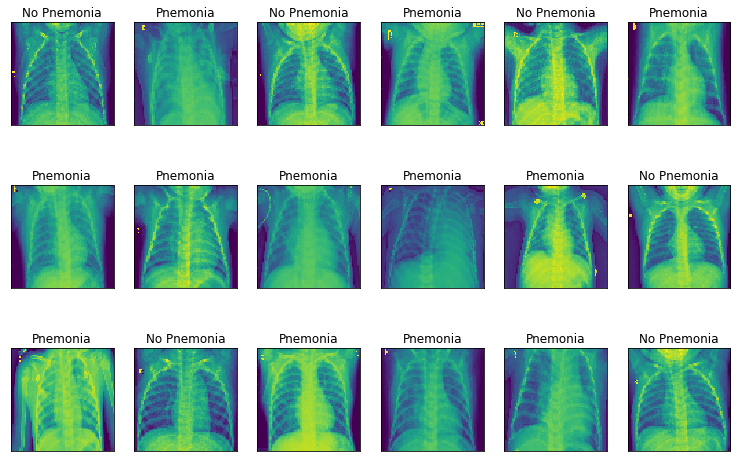

In [7]:
plot_gallery(X, y, 75, 75)

## Chosing a metric

In this case, I am trying to minimize the number of False Positives in the model.  This is because incorrectly guessing they have Pneumonia when they don't is not a big deal, the doctor can look at it and deem the patient healthy, or just be over cautious.  However, guessing the patient does not have Pneumonia when they do could have serious consequences.  Furthermore, in practice, the goal would be to use this algorithm to "shorten the stack" of xrays a radiologist would have to scan through.  Therefore, this algorithm can be effective, if it can predict when the patient has pneumonia better than a radiologist can (preferable next to perfect), but still effectiveily say when some do not in order to continue to stick the number of xrays that need to be sorted.

Therefore I will use a recall score.

## Splitting the data

The size of this dataset (about 11,000 obs.) put this models in an inbetween space.  We could probably get away with a shuffle split, espically if we were to stratify the split.  However, I will be using a Stratified 10 fold split becuase the cutoff for this as a rule of thumb is about 10,000 obs.  

# Modeling

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from sklearn.metrics import recall_score

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [9]:
%%time

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None)

#expand dimensions
X = np.expand_dims(X.reshape((-1, 75, 75)), axis=3)

datagen.fit(X)

tmps = datagen.flow(X, y, batch_size=1000)

CPU times: user 305 ms, sys: 195 ms, total: 499 ms
Wall time: 310 ms


In [10]:
i = 0
for tmp in tmps:
    if i == 1000: break
    i = i+1
    if i % 50 == 0: print("{} images added".format(i))
    X = np.vstack((X,np.expand_dims(tmp[0][0].squeeze().reshape((-1,75,75)), axis=3)))
    y = np.append(y,tmp[1][0])

50 images added
100 images added
150 images added
200 images added
250 images added
300 images added
350 images added
400 images added
450 images added
500 images added
550 images added
600 images added
650 images added
700 images added
750 images added
800 images added
850 images added
900 images added
950 images added
1000 images added


In [11]:
import pickle 

#store image dataset in pickle file
pickle.dump(X, open('image_data.p', 'wb'))
pickle.dump(y, open('image_labels.p', 'wb'))

In [12]:
import pickle

#load data from pickle file
X = pickle.load(open('image_data.p', 'rb'))
y = pickle.load(open('image_labels.p', 'rb'))

In [13]:
from keras.utils import to_categorical
y_binary = to_categorical(y)

In [14]:
from keras import backend as K

#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [15]:
cnn = Sequential()

cnn.add(Conv2D(filters=32,
                   input_shape = (75,75,1),
                   kernel_size= (3,3),
                   padding='same',
                   activation='relu',
                   data_format='channels_last'))

cnn.add(Conv2D(filters=64,
                    kernel_size=(3,3),
                    padding='same',
                    activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

cnn.add(Conv2D(filters=128,
                    kernel_size=(5,5),
                    padding='same',
                    activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation='softmax'))

cnn.compile(loss='binary_crossentropy',
                   optimizer='rmsprop',
                   metrics=[recall_m])

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
#To tune hyperparameters
import sklearn
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True).split(X, y)

In [17]:
#Just to compare the models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [18]:
fits = []
for k, (train, test) in enumerate(kfold):
    history = cnn.fit(X[train], y_binary[train], 
                batch_size=32,
                epochs=2, shuffle=True, verbose=1, 
                validation_data=(X[test],y_binary[test]), 
                callbacks=[EarlyStopping(monitor='val_loss', patience=2)])
    fits.append(history)

Instructions for updating:
Use tf.cast instead.
Train on 11412 samples, validate on 1268 samples
Epoch 1/2
11412/11412 [==============================] - 398s 35ms/step - loss: 4.3067 - recall_m: 0.7313 - val_loss: 4.2983 - val_recall_m: 0.7311
Epoch 2/2
11412/11412 [==============================] - 404s 35ms/step - loss: 4.2955 - recall_m: 0.7322 - val_loss: 4.2983 - val_recall_m: 0.7311
Train on 11412 samples, validate on 1268 samples
Epoch 1/2
11412/11412 [==============================] - 413s 36ms/step - loss: 4.2955 - recall_m: 0.7321 - val_loss: 4.2983 - val_recall_m: 0.7316
Epoch 2/2
11412/11412 [==============================] - 417s 37ms/step - loss: 4.2955 - recall_m: 0.7322 - val_loss: 4.2983 - val_recall_m: 0.7316
Train on 11412 samples, validate on 1268 samples
Epoch 1/2
11412/11412 [==============================] - 418s 37ms/step - loss: 4.2955 - recall_m: 0.7321 - val_loss: 4.2983 - val_recall_m: 0.7320
Epoch 2/2
11412/11412 [==============================] - 421s 37m

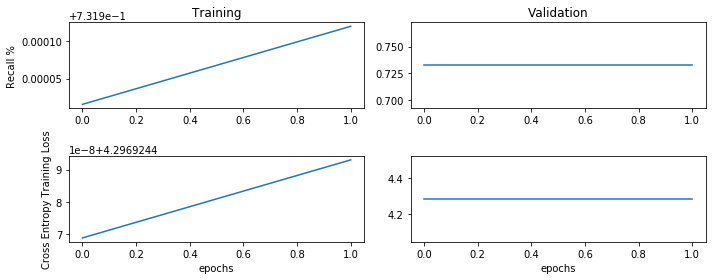

In [19]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(fits[-1].history['recall_m'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(fits[-1].history['val_recall_m'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(fits[-1].history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(fits[-1].history['val_loss'])
plt.xlabel('epochs')

plt.tight_layout()

In [20]:
from keras.models import model_from_json

cnn_json = cnn.to_json()
with open("cnn.json", "w") as json_file:
    json_file.write(cnn_json)
# serialize weights to HDF5
cnn.save_weights("cnn.h5")

print("Saved model to disk")

Saved model to disk


In [21]:
from keras.models import model_from_json
# load json and create model
json_file = open('cnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
cnn = model_from_json(loaded_model_json)
# load weights into new model
cnn.load_weights("cnn.h5")

print("Loaded model from disk")

Loaded model from disk


## Two different CNN arcitectures and parameters

In [22]:
#To tune hyperparameters
import sklearn
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True).split(X, y)

In [23]:
#I got this from https://www.geeksforgeeks.org/python-image-classification-using-keras/

#In this model, I tried to closely mimic Xception
Xception = Sequential()

Xception.add(Conv2D(filters=32, kernel_size=(5, 5),
                        border_mode='valid',
                        input_shape=(75,75,1)))
Xception.add(Activation('relu'))
Xception.add(Dropout(0.2))
Xception.add(Conv2D(filters=32, kernel_size=(5, 5)))
Xception.add(Activation('relu'))
Xception.add(Dropout(0.2))
Xception.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

Xception.add(Conv2D(filters=64, kernel_size=(3, 3), border_mode='valid'))
Xception.add(Activation('relu'))
Xception.add(Dropout(0.2))
Xception.add(Conv2D(filters=64, kernel_size=(3, 3)))
Xception.add(Activation('relu'))
Xception.add(Dropout(0.2))
Xception.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

Xception.add(Flatten())
Xception.add(Dense(100))
Xception.add(Activation('relu'))
Xception.add(Dropout(0.2))

Xception.add(Dense(2))
Xception.add(Activation('sigmoid'))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=32, kernel_size=(5, 5), input_shape=(75, 75, 1..., padding="valid")`
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, kernel_size=(3, 3), padding="valid")`
  app.launch_new_instance()


In [24]:
Xception.compile(loss='binary_crossentropy',
                   optimizer='rmsprop',
                   metrics=[recall_m])

In [25]:
Xception_fits = []
for k, (train, test) in enumerate(kfold):
    history = Xception.fit(X[train], y_binary[train], 
                batch_size=32,
                epochs=2, shuffle=True, verbose=1, 
                validation_data=(X[test],y_binary[test]), 
                callbacks=[EarlyStopping(monitor='val_loss', patience=2)])
    Xception_fits.append(history)

Train on 11412 samples, validate on 1268 samples
Epoch 1/2
11412/11412 [==============================] - 269s 24ms/step - loss: 4.3122 - recall_m: 0.7282 - val_loss: 4.2983 - val_recall_m: 0.7311
Epoch 2/2
11412/11412 [==============================] - 269s 24ms/step - loss: 4.2955 - recall_m: 0.7321 - val_loss: 4.2983 - val_recall_m: 0.7311
Train on 11412 samples, validate on 1268 samples
Epoch 1/2
11412/11412 [==============================] - 268s 23ms/step - loss: 4.2955 - recall_m: 0.7322 - val_loss: 4.2983 - val_recall_m: 0.7316
Epoch 2/2
11412/11412 [==============================] - 266s 23ms/step - loss: 4.2955 - recall_m: 0.7318 - val_loss: 4.2983 - val_recall_m: 0.7316
Train on 11412 samples, validate on 1268 samples
Epoch 1/2
11412/11412 [==============================] - 265s 23ms/step - loss: 4.2955 - recall_m: 0.7321 - val_loss: 4.2983 - val_recall_m: 0.7320
Epoch 2/2
11412/11412 [==============================] - 264s 23ms/step - loss: 4.2955 - recall_m: 0.7320 - val_l

Text(0.5, 0, 'epochs')

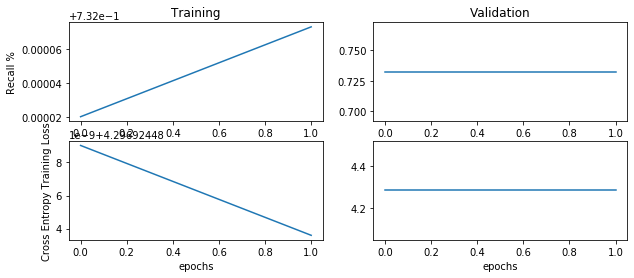

In [26]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(Xception_fits[-1].history['recall_m'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(Xception_fits[-1].history['val_recall_m'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(Xception_fits[-1].history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(Xception_fits[-1].history['val_loss'])
plt.xlabel('epochs')

In [29]:
from keras.models import model_from_json

Xception_json = cnn.to_json()
with open("Xception.json", "w") as json_file:
    json_file.write(Xception_json)
# serialize weights to HDF5
Xception.save_weights("Xception.h6")

print("Saved model to disk")

Saved model to disk


In [30]:
from keras.models import model_from_json
# load json and create model
json_file = open('Xception.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
Xception = model_from_json(loaded_model_json)
# load weights into new model
Xception.load_weights("Xception.h6")

print("Loaded model from disk")

Loaded model from disk


### Xception Modified

In [31]:
#To tune hyperparameters
import sklearn
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True).split(X, y)

In [32]:
#Model 2 is Xception that's been slightly modified
Xception_modified = Sequential()
Xception_modified.add(Conv2D(filters=32, 
                        kernel_size=(5, 5),
                        border_mode='valid',
                        input_shape=(75,75,1)))
Xception_modified.add(Activation('relu'))
Xception_modified.add(Dropout(0.2))
Xception_modified.add(Conv2D(filters=32, kernel_size=(5, 5)))
Xception_modified.add(Activation('relu'))
Xception_modified.add(Dropout(0.2))
Xception_modified.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last')) # I messed with the pooling here, was 2,2 now 3,3

Xception_modified.add(Conv2D(filters=64, kernel_size=(3, 3), border_mode='valid'))
Xception_modified.add(Activation('relu'))
Xception.add(Dropout(0.2))
Xception_modified.add(Conv2D(filters=64, kernel_size=(3, 3)))
Xception_modified.add(Activation('relu'))
Xception.add(Dropout(0.2))
Xception_modified.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last')) # I messed with the pooling here, was 2,2 now 3,3

#This part I added.  It functions similar to the above layer, but takes in 1x1 convolutions
#========================
Xception_modified.add(Conv2D(filters=64, kernel_size=(1, 1), border_mode='valid'))
Xception_modified.add(Activation('relu'))
Xception_modified.add(Conv2D(filters=64, kernel_size=(1, 1)))
Xception_modified.add(Activation('relu'))
Xception_modified.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))
#========================

Xception_modified.add(Flatten())
Xception_modified.add(Dense(100))
Xception_modified.add(Activation('relu'))
Xception_modified.add(Dropout(0.2))

Xception_modified.add(Dense(2))
Xception_modified.add(Activation('sigmoid'))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=32, kernel_size=(5, 5), input_shape=(75, 75, 1..., padding="valid")`
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, kernel_size=(3, 3), padding="valid")`
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, kernel_size=(1, 1), padding="valid")`


In [33]:
Xception_modified.compile(loss='binary_crossentropy', 
                   optimizer='rmsprop', 
                   metrics=[recall_m])

In [34]:
Xception_modified_fits = []
for k, (train, test) in enumerate(kfold):
    history = Xception_modified.fit(X[train], y_binary[train], 
                batch_size=32,
                epochs=2, shuffle=True, verbose=1, 
                validation_data=(X[test],y_binary[test]), 
                callbacks=[EarlyStopping(monitor='val_loss', patience=2)])
    Xception_modified_fits.append(history)

Train on 11412 samples, validate on 1268 samples
Epoch 1/2
11412/11412 [==============================] - 244s 21ms/step - loss: 5.3306 - recall_m: 0.5363 - val_loss: 4.2983 - val_recall_m: 0.7311
Epoch 2/2
11412/11412 [==============================] - 243s 21ms/step - loss: 4.3635 - recall_m: 0.7388 - val_loss: 4.2983 - val_recall_m: 0.7311
Train on 11412 samples, validate on 1268 samples
Epoch 1/2
11412/11412 [==============================] - 242s 21ms/step - loss: 4.2955 - recall_m: 0.7322 - val_loss: 4.2983 - val_recall_m: 0.7316
Epoch 2/2
11412/11412 [==============================] - 242s 21ms/step - loss: 2.5329 - recall_m: 0.7654 - val_loss: 0.3066 - val_recall_m: 0.9205
Train on 11412 samples, validate on 1268 samples
Epoch 1/2
11412/11412 [==============================] - 242s 21ms/step - loss: 0.2587 - recall_m: 0.9040 - val_loss: 0.1870 - val_recall_m: 0.9244
Epoch 2/2
11412/11412 [==============================] - 243s 21ms/step - loss: 0.2097 - recall_m: 0.9220 - val_l

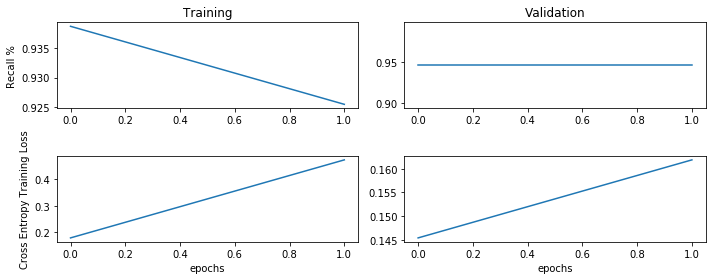

In [35]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(Xception_modified_fits[-1].history['recall_m'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(Xception_modified_fits[-1].history['val_recall_m'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(Xception_modified_fits[-1].history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(Xception_modified_fits[-1].history['val_loss'])
plt.xlabel('epochs')

plt.tight_layout()

In [36]:
from keras.models import model_from_json

Xception_modified_json = Xception_modified.to_json()
with open("Xception_modified.json", "w") as json_file:
    json_file.write(Xception_modified_json)
# serialize weights to HDF5
Xception_modified.save_weights("Xception_modified.h5")

print("Saved model to disk")

Saved model to disk


In [37]:
from keras.models import model_from_json
# load json and create model
json_file = open('Xception_modified.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
Xception_modified = model_from_json(loaded_model_json)
# load weights into new model
Xception_modified.load_weights("Xception_modified.h5")

print("Loaded model from disk")

Loaded model from disk


## Compare the CNN's

In [38]:
from scipy import stats 
recall_cnn = []
recall_Xception = []
recall_Xception_modified = []
for fit in fits:
    recall_cnn.append(fit.history["recall_m"][0])
    recall_cnn.append(fit.history["recall_m"][1])
for fit in Xception_fits:
    recall_Xception.append(fit.history["recall_m"][0])
    recall_Xception.append(fit.history["recall_m"][1])
for fit in Xception_modified_fits:
    recall_Xception_modified.append(fit.history["recall_m"][0])
    recall_Xception_modified.append(fit.history["recall_m"][1])
print(stats.ttest_ind(recall_Xception,recall_cnn, axis=0, equal_var = False))
print(stats.ttest_ind(recall_Xception_modified,recall_cnn, axis=0, equal_var = False))
print(stats.ttest_ind(recall_Xception,recall_Xception_modified, axis=0, equal_var = False))

Ttest_indResult(statistic=-0.8286936393531645, pvalue=0.4166151735119018)
Ttest_indResult(statistic=3.5518782594852047, pvalue=0.0021291153688182)
Ttest_indResult(statistic=-3.5581649959462616, pvalue=0.0020986314419629316)


From the results of the t-tests above.  We can conclude that Xception and our basic CNN both were not statistically significantly different.  However, Xception_modified was statistically significantly greater than both of the other models.

This is run slightly out of order bc I forgot to do the visuals for this part.

In [144]:
#Just to compare the models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [145]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred_cnn = np.argmax(cnn.predict(X_test), axis=1)

#false positve and true postive rates using roc
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(np.argmax(y_test,axis=1), y_pred_cnn)

#area under the curve
auc_cnn = auc(fpr_cnn, tpr_cnn)

y_pred_cnn2 = np.argmax(Xception.predict(X_test), axis=1)

#false positve and true postive rates using roc
fpr_cnn2, tpr_cnn2, thresholds_cnn2 = roc_curve(np.argmax(y_test,axis=1), y_pred_cnn2)

#area under the curve
auc_cnn2 = auc(fpr_cnn2, tpr_cnn2)


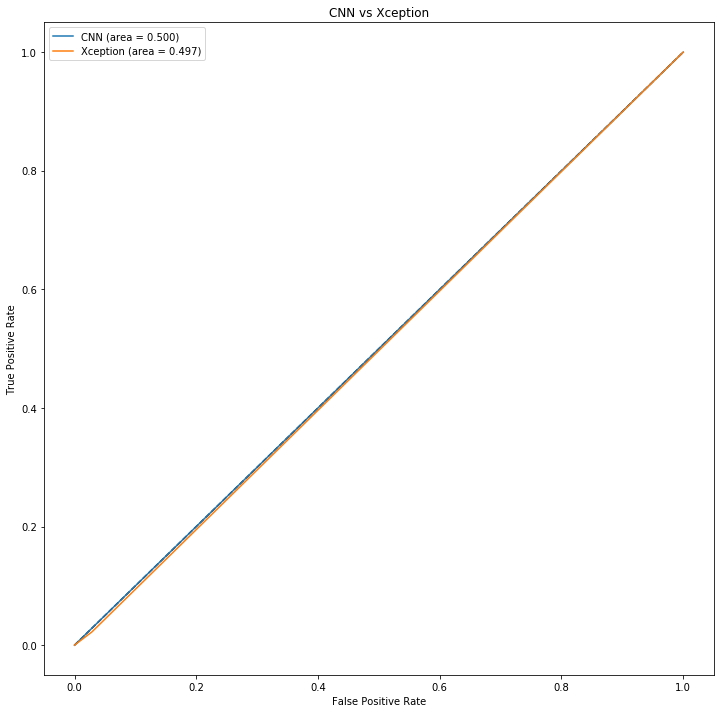

In [146]:
plt.figure(figsize=(12,12))

#plot halfway line
plt.plot([0,1], [0,1], 'k--')

#plot model 1 ROC
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))

#plot model 2 ROC
plt.plot(fpr_cnn2, tpr_cnn2, label='Xception (area = {:.3f})'.format(auc_cnn2))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN vs Xception')
plt.legend(loc='best')
plt.show()

In [147]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred_cnn = np.argmax(cnn.predict(grayscale_test), axis=1)

#false positve and true postive rates using roc
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(np.argmax(y_test,axis=1), y_pred_cnn)

#area under the curve
auc_cnn = auc(fpr_cnn, tpr_cnn)

y_pred_cnn2 = np.argmax(Xception_modified.predict(X_test), axis=1)

#false positve and true postive rates using roc
fpr_cnn2, tpr_cnn2, thresholds_cnn2 = roc_curve(np.argmax(y_test,axis=1), y_pred_cnn2)

#area under the curve
auc_cnn2 = auc(fpr_cnn2, tpr_cnn2)


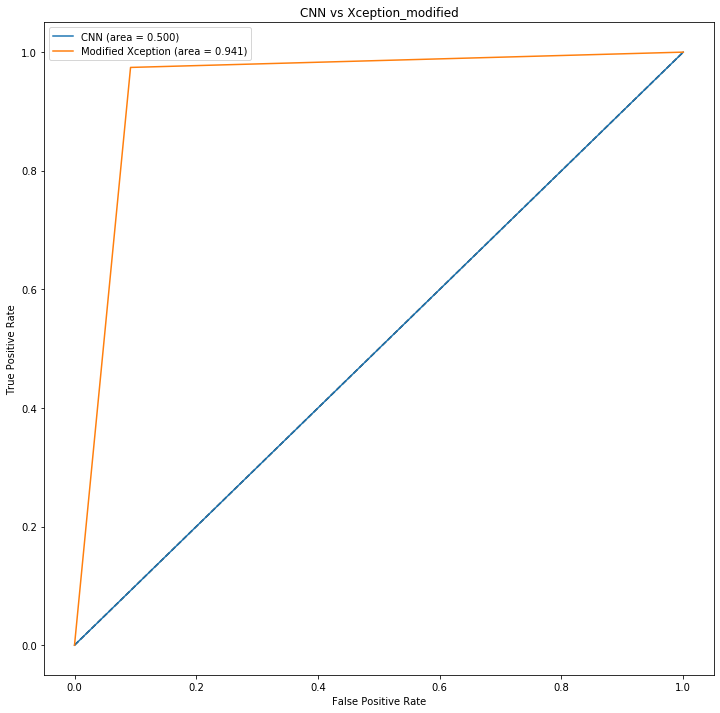

In [148]:
plt.figure(figsize=(12,12))

#plot halfway line
plt.plot([0,1], [0,1], 'k--')

#plot model 1 ROC
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))

#plot model 2 ROC
plt.plot(fpr_cnn2, tpr_cnn2, label='Modified Xception (area = {:.3f})'.format(auc_cnn2))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN vs Xception_modified')
plt.legend(loc='best')
plt.show()

In [149]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred_cnn = np.argmax(Xception.predict(grayscale_test), axis=1)

#false positve and true postive rates using roc
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(np.argmax(y_test,axis=1), y_pred_cnn)

#area under the curve
auc_cnn = auc(fpr_cnn, tpr_cnn)

y_pred_cnn2 = np.argmax(Xception_modified.predict(X_test), axis=1)

#false positve and true postive rates using roc
fpr_cnn2, tpr_cnn2, thresholds_cnn2 = roc_curve(np.argmax(y_test,axis=1), y_pred_cnn2)

#area under the curve
auc_cnn2 = auc(fpr_cnn2, tpr_cnn2)


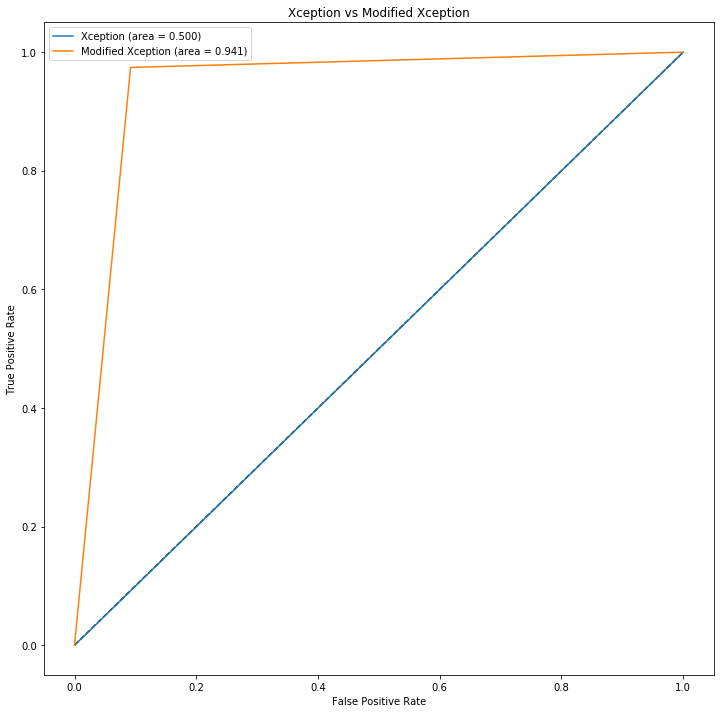

In [151]:
plt.figure(figsize=(12,12))

#plot halfway line
plt.plot([0,1], [0,1], 'k--')

#plot model 1 ROC
plt.plot(fpr_cnn, tpr_cnn, label='Xception (area = {:.3f})'.format(auc_cnn))

#plot model 2 ROC
plt.plot(fpr_cnn2, tpr_cnn2, label='Modified Xception (area = {:.3f})'.format(auc_cnn2))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Xception vs Modified Xception')
plt.legend(loc='best')
plt.show()

Ultimantily, these graphs further emphasize the lack of difference in the models between CNN and Xception, but how the modified exception model worked significantly better.

## Compare to MLP

In [39]:
flat_train = np.asarray([x.flatten() for x in X_train ])
flat_test = np.asarray([x.flatten() for x in X_test])
flat_train.shape

(10144, 5625)

In [40]:
mlp = Sequential()
mlp.add( Dense(input_dim=flat_train.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(2) )
mlp.add( Activation('softmax') )

mlp.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=[recall_m])

mlp.fit(flat_train, y_train, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1)

Epoch 1/15
10144/10144 [==============================] - 1s 91us/step - loss: 4.4517 - recall_m: 0.7223
Epoch 2/15
10144/10144 [==============================] - 1s 69us/step - loss: 4.2952 - recall_m: 0.7321
Epoch 3/15
10144/10144 [==============================] - 1s 69us/step - loss: 4.2952 - recall_m: 0.7321
Epoch 4/15
10144/10144 [==============================] - 1s 69us/step - loss: 4.2952 - recall_m: 0.7321
Epoch 5/15
10144/10144 [==============================] - 1s 68us/step - loss: 4.2952 - recall_m: 0.7321
Epoch 6/15
10144/10144 [==============================] - 1s 68us/step - loss: 4.2952 - recall_m: 0.7321
Epoch 7/15
10144/10144 [==============================] - 1s 69us/step - loss: 4.2952 - recall_m: 0.7321
Epoch 8/15
10144/10144 [==============================] - 1s 68us/step - loss: 4.2952 - recall_m: 0.7321
Epoch 9/15
10144/10144 [==============================] - 1s 68us/step - loss: 4.2952 - recall_m: 0.7321
Epoch 10/15
10144/10144 [==============================

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred_cnn = np.argmax(Xception_modified.predict(X_test), axis=1)

#false positve and true postive rates using roc
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(np.argmax(y_test,axis=1), y_pred_cnn)

#area under the curve
auc_cnn = auc(fpr_cnn, tpr_cnn)

y_pred_mlp = np.argmax(mlp.predict(flat_test), axis=1)

#false positve and true postive rates using roc
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(np.argmax(y_test, axis=1), y_pred_mlp)

#area under the curve
auc_mlp = auc(fpr_mlp, tpr_mlp)

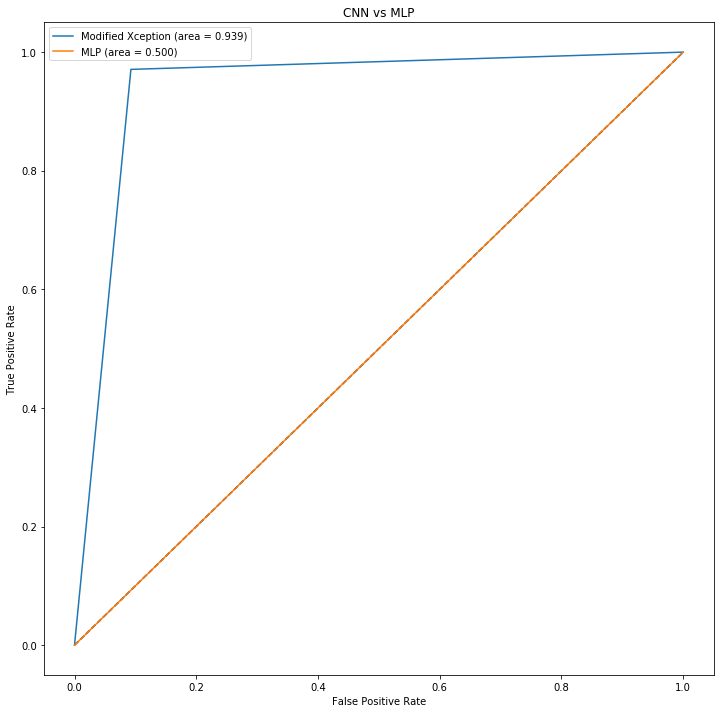

In [46]:
plt.figure(figsize=(12,12))

#plot halfway line
plt.plot([0,1], [0,1], 'k--')

#plot model 1 ROC
plt.plot(fpr_cnn, tpr_cnn, label='Modified Xception (area = {:.3f})'.format(auc_cnn))

#plot model 2 ROC
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN vs MLP')
plt.legend(loc='best')
plt.show()

From the graph above, it is clear that the Xception modified model out preformed the MLP by a fair margin.

# Exceptional Work

For this I am going to use the Keras implementation of Inception v3 with transfer learning and compare it against my best preforming CNN.

In [97]:
xrays = []
labels = []

In [98]:
#Read the images as numpy arrays
def read_xrays2(file_path, pneumonia = True):
    errors = 0
    all_xrays = glob.glob(file_path)
    for image in all_xrays:
        xray = cv2.imread(image)
        xray = cv2.resize(xray, dsize = (75,75), interpolation=cv2.INTER_NEAREST)
        try:
            xrays.append(xray)
            if pneumonia:
                labels.append(1)
            else:
                labels.append(0)
                
        except:
            errors += 1
    return errors

In [99]:
%%time

#Read in data and make sure everything work okay
num_errors = 0
num_errors += read_xrays2("chest_xray/chest_xray/train/NORMAL/*.jpeg", pneumonia = False)
num_errors += read_xrays2("chest_xray/chest_xray/test/NORMAL/*.jpeg", pneumonia = False)
num_errors += read_xrays2("chest_xray/train/NORMAL/*.jpeg", pneumonia = False)
num_errors += read_xrays2("chest_xray/test/NORMAL/*.jpeg", pneumonia = False)
num_errors += read_xrays2("chest_xray/val/NORMAL/*.jpeg", pneumonia = False)
print("Normal")
num_errors += read_xrays2("chest_xray/chest_xray/train/PNEUMONIA/*.jpeg", pneumonia = True)
num_errors += read_xrays2("chest_xray/chest_xray/test/PNEUMONIA/*.jpeg", pneumonia = True)
num_errors += read_xrays2("chest_xray/train/PNEUMONIA/*.jpeg", pneumonia = True)
num_errors += read_xrays2("chest_xray/test/PNEUMONIA/*.jpeg", pneumonia = True)
num_errors += read_xrays2("chest_xray/val/PNEUMONIA/*.jpeg", pneumonia = True)
print("Pneumonia")

if num_errors > 0:
    print(num_errors, "images did not read correctly")
else:
    print("All images read fine")

Normal
Pneumonia
All images read fine
CPU times: user 2min 7s, sys: 15.9 s, total: 2min 23s
Wall time: 2min 35s


In [100]:
X = np.array(xrays)
y = np.array(labels)

In [101]:
#I got this from https://keras.io/applications/
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import Input

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(2, activation='sigmoid')(x)

Inception = Model(inputs=base_model.input, outputs=predictions)

Inception.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=[recall_m])

In [102]:
#To tune hyperparameters
import sklearn
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True).split(X, y)

In [103]:
Inception_fits = []
for k, (train, test) in enumerate(kfold):
    history = Inception.fit(X[train], y_binary[train], 
                batch_size=32,
                epochs=2, shuffle=True, verbose=1, 
                validation_data=(X[test],y_binary[test]), 
                callbacks=[EarlyStopping(monitor='val_loss', patience=2)])
    Inception_fits.append(history)

Train on 10512 samples, validate on 1168 samples
Epoch 1/2
10512/10512 [==============================] - 438s 42ms/step - loss: 0.3503 - recall_m: 0.8976 - val_loss: 4.3240 - val_recall_m: 0.7340
Epoch 2/2
10512/10512 [==============================] - 432s 41ms/step - loss: 0.2109 - recall_m: 0.9443 - val_loss: 9.9660 - val_recall_m: 0.3716
Train on 10512 samples, validate on 1168 samples
Epoch 1/2
10512/10512 [==============================] - 428s 41ms/step - loss: 0.1511 - recall_m: 0.9609 - val_loss: 4.9984 - val_recall_m: 0.5253
Epoch 2/2
10512/10512 [==============================] - 428s 41ms/step - loss: 0.0929 - recall_m: 0.9715 - val_loss: 0.0809 - val_recall_m: 0.9713
Train on 10512 samples, validate on 1168 samples
Epoch 1/2
10512/10512 [==============================] - 425s 40ms/step - loss: 0.1528 - recall_m: 0.9678 - val_loss: 0.7404 - val_recall_m: 0.9890
Epoch 2/2
10512/10512 [==============================] - 424s 40ms/step - loss: 0.0558 - recall_m: 0.9835 - val_l

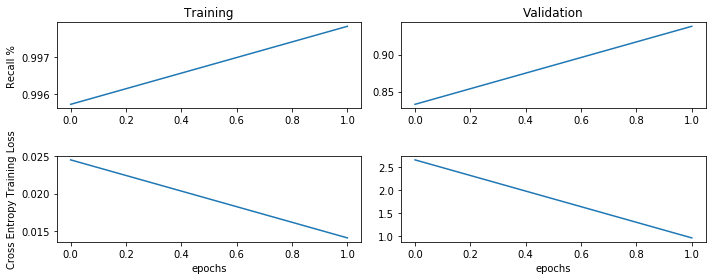

In [106]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(Inception_fits[-1].history['recall_m'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(Inception_fits[-1].history['val_recall_m'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(Inception_fits[-1].history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(Inception_fits[-1].history['val_loss'])
plt.xlabel('epochs')

plt.tight_layout()

In [107]:
from scipy import stats 
recall_Xception_modified = []
recall_Inception = []
for fit in Xception_modified_fits:
    recall_Xception_modified.append(fit.history["recall_m"][0])
    recall_Xception_modified.append(fit.history["recall_m"][1])
for fit in Inception_fits:
    recall_Inception.append(fit.history["recall_m"][0])
    recall_Inception.append(fit.history["recall_m"][1])
print(stats.ttest_ind(recall_Inception,recall_Xception_modified, axis=0, equal_var = False))

Ttest_indResult(statistic=6.075795577512802, pvalue=5.21466693180885e-06)


In [125]:
#Just to compare the models
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
grayscale_test = rgb2gray(X_test)
grayscale_test = np.expand_dims(grayscale_test.reshape((-1, 75, 75)), axis=3)

In [128]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred_cnn = np.argmax(Xception_modified.predict(grayscale_test), axis=1)

#false positve and true postive rates using roc
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(np.argmax(y_test,axis=1), y_pred_cnn)

#area under the curve
auc_cnn = auc(fpr_cnn, tpr_cnn)

y_pred_cnn2 = np.argmax(Inception.predict(X_test), axis=1)

#false positve and true postive rates using roc
fpr_cnn2, tpr_cnn2, thresholds_cnn2 = roc_curve(np.argmax(y_test,axis=1), y_pred_cnn2)

#area under the curve
auc_cnn2 = auc(fpr_cnn2, tpr_cnn2)


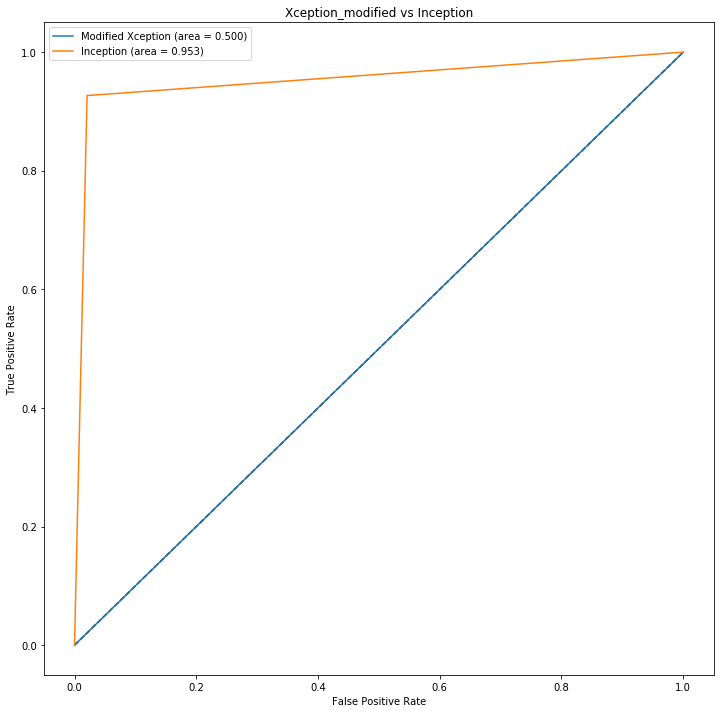

In [129]:
plt.figure(figsize=(12,12))

#plot halfway line
plt.plot([0,1], [0,1], 'k--')

#plot model 1 ROC
plt.plot(fpr_cnn, tpr_cnn, label='Modified Xception (area = {:.3f})'.format(auc_cnn))

#plot model 2 ROC
plt.plot(fpr_cnn2, tpr_cnn2, label='Inception (area = {:.3f})'.format(auc_cnn2))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Xception_modified vs Inception')
plt.legend(loc='best')
plt.show()

Results from the t-test show At a significance level of 0.05 and a p-value < 1e-6.  There is sufficent evidence to conclude that the recall score of Inception is greater than that of Xception Modified.

From the roc test, Xception modified clearly does not preform as well as Inception.  This graph deos seem odd because Xception Modified early had a ROC of .939.  Even still, Inception's .953 ROC makes Inception the slightly better model.